## TRAVELING SALESMAN PROBLEM WITH GNN ON REAL-WORLD ROAD NETWORKS

Project Overview:
-----------------
This notebook implements a Graph Neural Network approach to the Traveling
Salesman Problem using REAL-WORLD road networks from OpenStreetMap. Instead
of synthetic data, we work with actual city street networks to test whether
neural approaches can handle real geographical constraints.

Research Question:
------------------
Can a GNN trained on real-world road networks learn effective routing patterns
and generalize to different cities and network sizes compared to classical
heuristics?

Key Differences from Synthetic Approach:
-----------------------------------------
1. Real road networks (not complete graphs)
2. Actual geographic constraints
3. Non-uniform node distributions
4. Realistic distance metrics
5. Network topology matters (dead ends, highways, etc.)

Author: Asma Benzaied et Nouha Aouachri
Date: January 2026

# ENVIRONMENT SETUP

👉 Objectif : installer les bibliothèques nécessaires.


*   torch-geometric : pour **construire** et **entraîner** le modèle GNN.
*  python-tsp : pour résoudre le TSP avec des méthodes classiques et comparer les résultats.
* osmnx et networkx : pour télécharger et **manipuler les graphes routiers réels depuis OpenStreetMap.**
****








In [ ]:

!pip install -q torch-geometric
!pip install -q python-tsp
!pip install -q osmnx networkx

print("✅ Packages installed! If prompted, restart runtime and continue.")

✅ Packages installed! If prompted, restart runtime and continue.


# IMPORTS AND CONFIGURATION

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing
import random
from tqdm import tqdm
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✅ All imports successful!")


Using device: cuda
✅ All imports successful!


# REAL-WORLD ROAD NETWORK DATA LOADING

👉 Objectif : télécharger et manipuler les réseaux routiers réels.

Fonctions principales :
1.  load_city_network(): télécharge un graphe routier complet pour une ville donnée.
2.   extract_subgraph() : extrait un sous-graphe connecté pour créer un mini-problème TSP.
3. compute_real_distances() : calcule **les distances réelles** de conduite entre les nœuds et non pas les distances euclidiennes.









In [ ]:

def load_city_network(city_name, network_type='drive', simplify=True):
    """
    Load real road network from OpenStreetMap.

    Args:
        city_name (str): City name or address
        network_type (str): 'drive', 'walk', 'bike', or 'all'
        simplify (bool): Simplify network topology

    Returns:
        G (networkx.MultiDiGraph): Road network graph
    """
    print(f"📍 Downloading road network for: {city_name}")
    try:
        G = ox.graph_from_place(city_name, network_type=network_type, simplify=simplify)
        print(f"   ✅ Loaded: {len(G.nodes)} nodes, {len(G.edges)} edges")
        return G
    except Exception as e:
        print(f"   ❌ Error loading {city_name}: {e}")
        return None


def extract_subgraph(G, n_nodes=20, seed=None):
    """
    Extract a connected subgraph from the city network.

    This creates TSP instances of manageable size while preserving
    the real-world network structure and constraints.

    Args:
        G (networkx.Graph): Full city network
        n_nodes (int): Desired number of nodes
        seed (int): Random seed for reproducibility

    Returns:
        subgraph (networkx.Graph): Connected subgraph
        node_positions (dict): {node_id: (x, y)} coordinates
    """
    if seed is not None:
        random.seed(seed)

    # Convert to undirected for simpler handling
    G_undirected = G.to_undirected()

    # Get largest connected component
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_connected = G_undirected.subgraph(largest_cc).copy()

    # Randomly sample starting node
    all_nodes = list(G_connected.nodes())
    if len(all_nodes) < n_nodes:
        print(f"   ⚠️  Network only has {len(all_nodes)} nodes, using all")
        n_nodes = len(all_nodes)

    start_node = random.choice(all_nodes)

    # Grow subgraph using BFS to ensure connectivity
    selected_nodes = {start_node}
    frontier = list(G_connected.neighbors(start_node))

    while len(selected_nodes) < n_nodes and frontier:
        next_node = random.choice(frontier)
        frontier.remove(next_node)

        if next_node not in selected_nodes:
            selected_nodes.add(next_node)
            # Add neighbors to frontier
            for neighbor in G_connected.neighbors(next_node):
                if neighbor not in selected_nodes and neighbor not in frontier:
                    frontier.append(neighbor)

    # Extract subgraph
    subgraph = G_connected.subgraph(selected_nodes).copy()

    # Get node positions (lat, lon)
    node_positions = {}
    for node in subgraph.nodes():
        node_data = G_connected.nodes[node]
        # Project to local coordinates (meters from centroid)
        node_positions[node] = (node_data['x'], node_data['y'])

    return subgraph, node_positions


def compute_real_distances(subgraph, node_positions):
    """
    Compute shortest path distances on the actual road network.

    This is CRUCIAL: we use real driving distances, not Euclidean!

    Args:
        subgraph (networkx.Graph): Road network
        node_positions (dict): Node coordinates

    Returns:
        node_list (list): Ordered list of nodes
        coords (np.array): Node coordinates (n, 2)
        dist_matrix (np.array): Real shortest-path distances (n, n)
    """
    node_list = list(subgraph.nodes())
    n = len(node_list)

    # Get coordinates
    coords = np.array([node_positions[node] for node in node_list])

    # Compute all-pairs shortest paths on road network
    print(f"   Computing shortest paths for {n} nodes...")
    dist_matrix = np.zeros((n, n))

    # Add edge weights (length in meters)
    for u, v, data in subgraph.edges(data=True):
        if 'length' not in data:
            # Calculate Euclidean distance if length not available
            pos_u = node_positions[u]
            pos_v = node_positions[v]
            data['length'] = np.sqrt((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)

    # Compute shortest paths
    try:
        all_paths = dict(nx.all_pairs_dijkstra_path_length(subgraph, weight='length'))

        for i, node_i in enumerate(node_list):
            for j, node_j in enumerate(node_list):
                if i == j:
                    dist_matrix[i, j] = 0
                elif node_j in all_paths[node_i]:
                    dist_matrix[i, j] = all_paths[node_i][node_j]
                else:
                    # If no path exists (shouldn't happen with connected component)
                    dist_matrix[i, j] = np.inf
    except:
        # Fallback to Euclidean if shortest path computation fails
        print("   ⚠️  Using Euclidean distances (fallback)")
        for i in range(n):
            for j in range(n):
                dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])

    return node_list, coords, dist_matrix


Visualisation d'un réseau routier réel avant de passer a l'entraînement du modèle(GNN) depuis OpenStreetMap,ici on a selectionner  une ville test (Piedmont) pour extraire un petit sous-graphe(les nœuds = intersections,les arêtes = routes entre intersections,les attributs = longueur)
Execution:
1. OSMnx a téléchargé le réseau routier de Piedmont qui contient 352 intersections et 944 routes.
2.   Élément de liste




LOADING REAL-WORLD ROAD NETWORKS
📍 Downloading road network for: Piedmont, California, USA
   ✅ Loaded: 352 nodes, 944 edges
   Computing shortest paths for 30 nodes...

✅ Successfully extracted subgraph:
   Nodes: 30
   Average distance: 433.77 meters


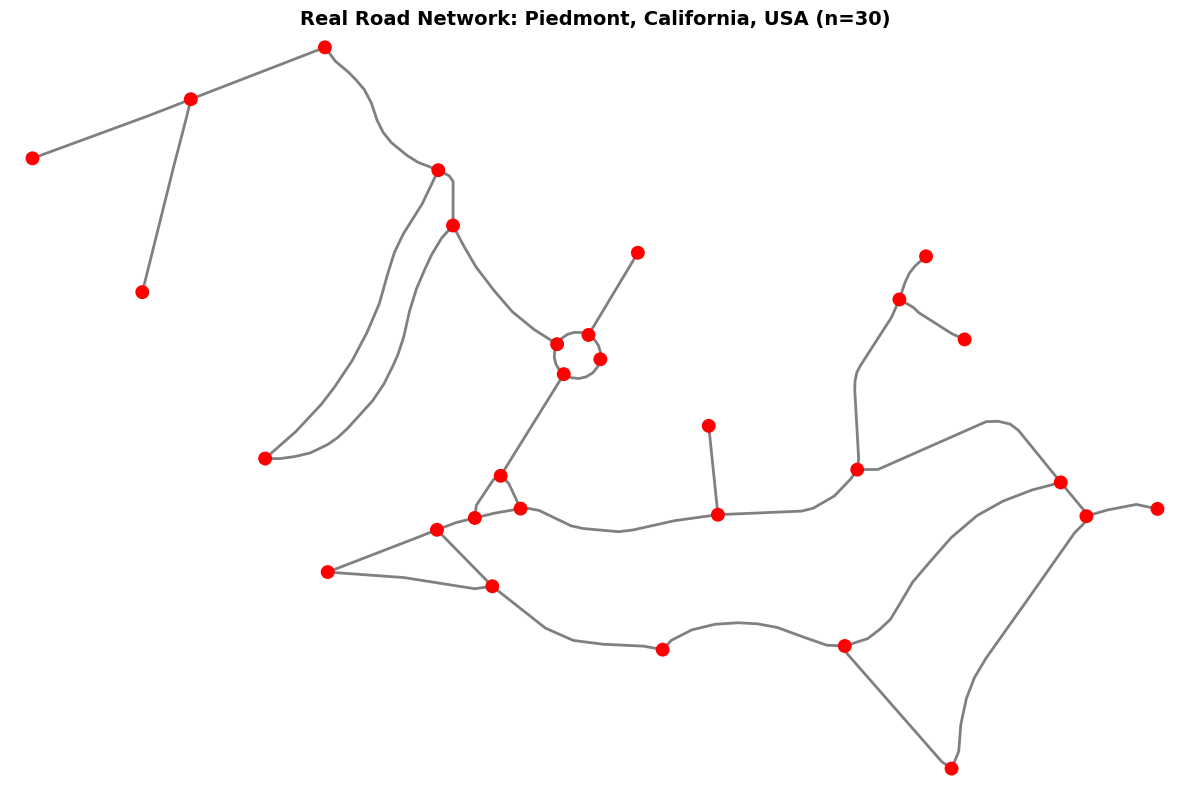

In [ ]:
# Test: Load a real city network
print("\n" + "="*70)
print("LOADING REAL-WORLD ROAD NETWORKS")
print("="*70)

# Load a sample city (try multiple for diversity)
test_city = "Piedmont, California, USA"  # Small city, loads quickly
G_test = load_city_network(test_city, network_type='drive')

if G_test is not None:
    # Extract a small subgraph for testing
    subgraph_test, positions_test = extract_subgraph(G_test, n_nodes=30, seed=42)
    node_list_test, coords_test, dist_test = compute_real_distances(subgraph_test, positions_test)

    print(f"\n✅ Successfully extracted subgraph:")
    print(f"   Nodes: {len(coords_test)}")
    print(f"   Average distance: {dist_test[dist_test > 0].mean():.2f} meters")

    # Visualize the real road network
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ox.plot_graph(subgraph_test, ax=ax, node_size=100, node_color='red',
                  edge_color='gray', edge_linewidth=2, show=False, close=False)
    ax.set_title(f"Real Road Network: {test_city} (n={len(coords_test)})",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Failed to load test city. Check internet connection.")

#  DATASET GENERATION FROM MULTIPLE CITIES

Pour chaque ville, le graphe complet est chargé depuis OpenStreetMap via OSMnx.

Pour chaque instance à générer :
1. Un nombre aléatoire de nœuds est choisi dans l’intervalle défini(dans notre exemple nous avons choisis n_nodes=30)
2. Un sous-graphe connecté est extrait à partir du graphe complet.
3. La matrice des distances réelles entre tous les nœuds du sous-graphe est calculée.
4. Le TSP est résolu de manière optimale pour obtenir le tour optimal et la distance totale.
5. L’instance complète (coordonnées, matrice de distances, tour optimal, distance, ville) est ajoutée au dataset.

Output: En fin en va avoir une dataset contenant plusieurs instances TSP issues de villes réelles .





In [ ]:

def generate_real_world_dataset(cities, n_instances_per_city=10,
                                n_nodes_range=(10, 15)):
    """
    Generate TSP instances from real road networks.

    Strategy:
    - Sample from multiple cities for diversity
    - Extract subgraphs of varying sizes
    - Compute real shortest-path distances
    - Solve optimally for labels

    Args:
        cities (list): List of city names
        n_instances_per_city (int): Instances per city
        n_nodes_range (tuple): (min, max) nodes per instance

    Returns:
        dataset (list): List of (coords, dist_matrix, tour, distance) tuples
        city_labels (list): Which city each instance came from
    """
    dataset = []
    city_labels = []

    print("\n" + "="*70)
    print("GENERATING REAL-WORLD TRAINING DATASET")
    print("="*70)
    print(f"Cities: {len(cities)}")
    print(f"Instances per city: {n_instances_per_city}")
    print(f"Node range: {n_nodes_range}")
    print("="*70 + "\n")

    for city in cities:
        print(f"\n🏙️  Processing: {city}")

        # Load city network
        G = load_city_network(city, network_type='drive')
        if G is None:
            print(f"   ⚠️  Skipping {city} (load failed)")
            continue

        # Generate multiple instances from this city
        success_count = 0
        attempts = 0
        max_attempts = n_instances_per_city * 3

        pbar = tqdm(total=n_instances_per_city, desc=f"   Generating")

        while success_count < n_instances_per_city and attempts < max_attempts:
            attempts += 1

            try:
                # Random instance size
                n_nodes = random.randint(n_nodes_range[0], n_nodes_range[1])

                # Extract subgraph
                subgraph, positions = extract_subgraph(G, n_nodes=n_nodes,
                                                       seed=None)

                # Compute distances
                node_list, coords, dist_matrix = compute_real_distances(subgraph, positions)

                # Skip if too few nodes
                if len(coords) < n_nodes_range[0]:
                    continue

                # Solve TSP optimally
                tour, distance = solve_tsp_optimal(dist_matrix)

                # Store instance
                dataset.append({
                    'coords': coords,
                    'dist_matrix': dist_matrix,
                    'tour': tour,
                    'distance': distance,
                    'city': city,
                    'n_nodes': len(coords)
                })
                city_labels.append(city)

                success_count += 1
                pbar.update(1)

            except Exception as e:
                continue

        pbar.close()
        print(f"   ✅ Generated {success_count} instances")

    print(f"\n{'='*70}")
    print(f"✅ DATASET COMPLETE: {len(dataset)} total instances")
    print(f"{'='*70}\n")

    return dataset, city_labels


**Résolution du TSP pour un sous-graphe**

Cette fonction prend la matrice des distances d'un sous-graphe et renvoie un tour TSP :
1.   Pour les petits graphes (≤ 20 nœuds) : on utilise la programmation dynamique pour obtenir le tour optimal exact.
2.   Pour les grands graphes (> 20 nœuds) : on utilise **une heuristique (Simulated Annealing)** pour obtenir une bonne approximation rapidement.

output:


1. permutation : ordre des nœuds à visiter pour former le tour (TSP).
2. distance : longueur totale du tour








In [ ]:
def solve_tsp_optimal(dist_matrix, max_size=20):
    """Solve TSP optimally (same as before)."""
    n = len(dist_matrix)

    if n > max_size:
        permutation, distance = solve_tsp_simulated_annealing(dist_matrix)
        return permutation, distance
    else:
        permutation, distance = solve_tsp_dynamic_programming(dist_matrix)
        return permutation, distance

- TRAINING_CITIES : liste des villes utilisées pour créer le dataset.
- generate_real_world_dataset() :
1.   Télécharge les graphes routiers réels de chaque ville via OSMnx.
2.   Génère plusieurs sous-graphes aléatoires par ville (ici 20 instances par ville).
3. Calcule la matrice des distances réelles pour chaque sous-graphe.
4.  Résout le TSP pour chaque sous-graphe afin d'obtenir les tours optimaux.
 - real_dataset : contient toutes les instances avec coordonnées, matrice de distances et tour optimal.
 - real_city_labels : indique la ville d'origine de chaque instance.

 - output, le code calcule et affiche des statistiques simples du dataset :
1. Nombre total d'instance: 100 (5 villes × 20 instances par ville = 100 instances TSP générées.)
2. Nombre moyen de nœuds par instance: la moyenne sur les 100 instances est 12,6 avec un écart type de 1,6.
3. Longueur moyenne des tours:2 503,8 mètres qui represente la distance moyenne du tour TSP optimal calculé pour toutes les instances.
4. Nombre de villes représentées:5(Piedmont, Berkeley, Alameda, Albany et Emeryville.)







In [ ]:
# Generate training data from multiple cities
TRAINING_CITIES = [
    "Piedmont, California, USA",
    "Berkeley, California, USA",
    "Alameda, California, USA",
    "Albany, California, USA",
    "Emeryville, California, USA"
]

print("   (Downloading real road networks and solving TSP instances)\n")

# Generate dataset
real_dataset, real_city_labels = generate_real_world_dataset(
    TRAINING_CITIES,
    n_instances_per_city=20,  # 20 instances × 5 cities = 100 total
    n_nodes_range=(10, 15)
)

# Statistics
if real_dataset:
    sizes = [d['n_nodes'] for d in real_dataset]
    distances = [d['distance'] for d in real_dataset]

    print("📊 DATASET STATISTICS:")
    print(f"   Total instances: {len(real_dataset)}")
    print(f"   Nodes per instance: {np.mean(sizes):.1f} ± {np.std(sizes):.1f}")
    print(f"   Average tour length: {np.mean(distances):.1f} meters")
    print(f"   Cities represented: {len(set(real_city_labels))}")

⏳ This will take 10-20 minutes depending on internet speed...
   (Downloading real road networks and solving TSP instances)


GENERATING REAL-WORLD TRAINING DATASET
Cities: 5
Instances per city: 20
Node range: (10, 15)


🏙️  Processing: Piedmont, California, USA
📍 Downloading road network for: Piedmont, California, USA
   ✅ Loaded: 352 nodes, 944 edges


   Generating:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 10 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  15%|█▌        | 3/20 [00:01<00:06,  2.72it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  25%|██▌       | 5/20 [00:02<00:06,  2.36it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  35%|███▌      | 7/20 [00:02<00:03,  3.52it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 10 nodes...


   Generating:  45%|████▌     | 9/20 [00:03<00:02,  3.87it/s]

   Computing shortest paths for 14 nodes...


   Generating:  50%|█████     | 10/20 [00:03<00:03,  2.62it/s]

   Computing shortest paths for 13 nodes...


   Generating:  60%|██████    | 12/20 [00:04<00:02,  3.31it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  85%|████████▌ | 17/20 [00:05<00:00,  4.34it/s]

   Computing shortest paths for 10 nodes...
   Computing shortest paths for 10 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  90%|█████████ | 18/20 [00:07<00:01,  1.91it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 13 nodes...


   Generating: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


   ✅ Generated 20 instances

🏙️  Processing: Berkeley, California, USA
📍 Downloading road network for: Berkeley, California, USA
   ✅ Loaded: 2163 nodes, 5823 edges


   Generating:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


   Generating:   5%|▌         | 1/20 [00:01<00:37,  2.00s/it]

   Computing shortest paths for 14 nodes...


   Generating:  10%|█         | 2/20 [00:02<00:22,  1.23s/it]

   Computing shortest paths for 14 nodes...


   Generating:  15%|█▌        | 3/20 [00:04<00:22,  1.31s/it]

   Computing shortest paths for 15 nodes...


   Generating:  25%|██▌       | 5/20 [00:06<00:18,  1.26s/it]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  30%|███       | 6/20 [00:08<00:19,  1.39s/it]

   Computing shortest paths for 13 nodes...


   Generating:  35%|███▌      | 7/20 [00:09<00:16,  1.23s/it]

   Computing shortest paths for 13 nodes...


   Generating:  40%|████      | 8/20 [00:11<00:16,  1.35s/it]

   Computing shortest paths for 13 nodes...


   Generating:  50%|█████     | 10/20 [00:13<00:12,  1.28s/it]

   Computing shortest paths for 13 nodes...


   Generating:  55%|█████▌    | 11/20 [00:13<00:08,  1.01it/s]

   Computing shortest paths for 12 nodes...


   Generating:  60%|██████    | 12/20 [00:14<00:06,  1.15it/s]

   Computing shortest paths for 11 nodes...


   Generating:  65%|██████▌   | 13/20 [00:14<00:05,  1.36it/s]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 12 nodes...


   Generating:  70%|███████   | 14/20 [00:15<00:04,  1.44it/s]

   Computing shortest paths for 15 nodes...


   Generating:  80%|████████  | 16/20 [00:18<00:03,  1.03it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  85%|████████▌ | 17/20 [00:18<00:02,  1.20it/s]

   Computing shortest paths for 14 nodes...


   Generating:  95%|█████████▌| 19/20 [00:20<00:00,  1.15it/s]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 13 nodes...


   Generating: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


   ✅ Generated 20 instances

🏙️  Processing: Alameda, California, USA
📍 Downloading road network for: Alameda, California, USA
   ✅ Loaded: 41832 nodes, 103270 edges


   Generating:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


   Generating:   5%|▌         | 1/20 [00:07<02:14,  7.09s/it]

   Computing shortest paths for 15 nodes...


   Generating:  10%|█         | 2/20 [00:15<02:23,  7.99s/it]

   Computing shortest paths for 15 nodes...


   Generating:  15%|█▌        | 3/20 [00:23<02:11,  7.76s/it]

   Computing shortest paths for 15 nodes...


   Generating:  25%|██▌       | 5/20 [00:37<01:47,  7.20s/it]

   Computing shortest paths for 11 nodes...


   Generating:  30%|███       | 6/20 [00:45<01:44,  7.45s/it]

   Computing shortest paths for 11 nodes...


   Generating:  35%|███▌      | 7/20 [00:53<01:42,  7.85s/it]

   Computing shortest paths for 13 nodes...


   Generating:  40%|████      | 8/20 [01:00<01:28,  7.38s/it]

   Computing shortest paths for 12 nodes...


   Generating:  45%|████▌     | 9/20 [01:06<01:18,  7.14s/it]

   Computing shortest paths for 10 nodes...


   Generating:  50%|█████     | 10/20 [01:13<01:09,  6.94s/it]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  60%|██████    | 12/20 [01:28<00:56,  7.11s/it]

   Computing shortest paths for 10 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  70%|███████   | 14/20 [01:42<00:41,  6.86s/it]

   Computing shortest paths for 12 nodes...


   Generating:  75%|███████▌  | 15/20 [01:49<00:34,  6.90s/it]

   Computing shortest paths for 13 nodes...


   Generating:  80%|████████  | 16/20 [01:55<00:26,  6.55s/it]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  90%|█████████ | 18/20 [02:09<00:13,  6.67s/it]

   Computing shortest paths for 12 nodes...


   Generating:  95%|█████████▌| 19/20 [02:15<00:06,  6.63s/it]

   Computing shortest paths for 10 nodes...


   Generating: 100%|██████████| 20/20 [02:21<00:00,  7.06s/it]

   Computing shortest paths for 10 nodes...
   ✅ Generated 20 instances

🏙️  Processing: Albany, California, USA
📍 Downloading road network for: Albany, California, USA


   ✅ Loaded: 272 nodes, 739 edges


   Generating:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 12 nodes...


   Generating:   5%|▌         | 1/20 [00:01<00:25,  1.32s/it]

   Computing shortest paths for 10 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  25%|██▌       | 5/20 [00:02<00:04,  3.01it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 12 nodes...


   Generating:  35%|███▌      | 7/20 [00:02<00:02,  4.43it/s]

   Computing shortest paths for 14 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  50%|█████     | 10/20 [00:03<00:03,  2.82it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 10 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  60%|██████    | 12/20 [00:04<00:02,  3.12it/s]

   Computing shortest paths for 15 nodes...


   Generating:  70%|███████   | 14/20 [00:06<00:02,  2.06it/s]

   Computing shortest paths for 13 nodes...


   Generating:  75%|███████▌  | 15/20 [00:06<00:02,  1.94it/s]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  90%|█████████ | 18/20 [00:07<00:00,  3.20it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 12 nodes...


   Generating: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


   ✅ Generated 20 instances

🏙️  Processing: Emeryville, California, USA
📍 Downloading road network for: Emeryville, California, USA
   ✅ Loaded: 219 nodes, 499 edges


   Generating:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


   Generating:   5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

   Computing shortest paths for 14 nodes...


   Generating:  10%|█         | 2/20 [00:02<00:19,  1.09s/it]

   Computing shortest paths for 15 nodes...


   Generating:  15%|█▌        | 3/20 [00:03<00:21,  1.29s/it]

   Computing shortest paths for 15 nodes...


   Generating:  20%|██        | 4/20 [00:05<00:23,  1.45s/it]

   Computing shortest paths for 10 nodes...
   Computing shortest paths for 11 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  35%|███▌      | 7/20 [00:05<00:07,  1.68it/s]

   Computing shortest paths for 14 nodes...


   Generating:  40%|████      | 8/20 [00:06<00:07,  1.54it/s]

   Computing shortest paths for 15 nodes...


   Generating:  45%|████▌     | 9/20 [00:08<00:09,  1.16it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 15 nodes...


   Generating:  55%|█████▌    | 11/20 [00:10<00:08,  1.08it/s]

   Computing shortest paths for 15 nodes...


   Generating:  65%|██████▌   | 13/20 [00:13<00:07,  1.05s/it]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 13 nodes...


   Generating:  70%|███████   | 14/20 [00:13<00:04,  1.21it/s]

   Computing shortest paths for 11 nodes...
   Computing shortest paths for 11 nodes...


   Generating:  80%|████████  | 16/20 [00:13<00:02,  1.70it/s]

   Computing shortest paths for 12 nodes...
   Computing shortest paths for 14 nodes...


   Generating:  95%|█████████▌| 19/20 [00:14<00:00,  2.27it/s]

   Computing shortest paths for 13 nodes...
   Computing shortest paths for 13 nodes...


   Generating: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

   ✅ Generated 20 instances

✅ DATASET COMPLETE: 100 total instances

📊 DATASET STATISTICS:
   Total instances: 100
   Nodes per instance: 12.6 ± 1.6
   Average tour length: 2503.8 meters
   Cities represented: 5


# BASELINE ALGORITHMS

In [ ]:
def nearest_neighbor_tsp(dist_matrix, start_node=0):
    """Nearest Neighbor heuristic."""
    n = len(dist_matrix)
    unvisited = set(range(n))
    tour = [start_node]
    unvisited.remove(start_node)

    current = start_node
    total_distance = 0

    while unvisited:
        nearest = min(unvisited, key=lambda x: dist_matrix[current][x])
        total_distance += dist_matrix[current][nearest]
        tour.append(nearest)
        unvisited.remove(nearest)
        current = nearest

    total_distance += dist_matrix[current][start_node]
    return tour, total_distance


def christofides_approx(dist_matrix):
    """Christofides algorithm."""
    G = nx.Graph()
    n = len(dist_matrix)

    for i in range(n):
        for j in range(i+1, n):
            if dist_matrix[i][j] < np.inf:
                G.add_edge(i, j, weight=dist_matrix[i][j])

    try:
        tour = nx.approximation.christofides(G, weight='weight')
        distance = sum(dist_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))
        return tour[:-1], distance
    except:
        # Fallback to nearest neighbor if Christofides fails
        return nearest_neighbor_tsp(dist_matrix)


In [ ]:
# Benchmark baselines on real data
print("\n" + "="*70)
print("BENCHMARKING BASELINES ON REAL-WORLD DATA")
print("="*70)

if real_dataset:
    baseline_results = {
        'optimal': [],
        'nearest_neighbor': [],
        'christofides': []
    }

    print(f"Testing on {min(20, len(real_dataset))} instances...\n")

    for instance in tqdm(real_dataset[:20], desc="Evaluating"):
        dist_matrix = instance['dist_matrix']
        opt_dist = instance['distance']

        baseline_results['optimal'].append(opt_dist)

        _, nn_dist = nearest_neighbor_tsp(dist_matrix)
        baseline_results['nearest_neighbor'].append(nn_dist)

        _, chr_dist = christofides_approx(dist_matrix)
        baseline_results['christofides'].append(chr_dist)

    # Display results
    print("\n📊 BASELINE RESULTS ON REAL NETWORKS:\n")
    for method in ['nearest_neighbor', 'christofides']:
        gaps = [(baseline_results[method][i] / baseline_results['optimal'][i] - 1) * 100
                for i in range(len(baseline_results['optimal']))]
        print(f"{method.upper().replace('_', ' ')}:")
        print(f"  Average gap: {np.mean(gaps):.2f}% (±{np.std(gaps):.2f}%)")
        print()


BENCHMARKING BASELINES ON REAL-WORLD DATA
Testing on 20 instances...



Evaluating: 100%|██████████| 20/20 [00:00<00:00, 721.38it/s]


📊 BASELINE RESULTS ON REAL NETWORKS:

NEAREST NEIGHBOR:
  Average gap: 3.80% (±6.62%)

CHRISTOFIDES:
  Average gap: 1.62% (±5.48%)



# GNN MODEL (Same Architecture)

In [ ]:
class TSP_GNN(nn.Module):
    """Graph Neural Network for TSP Edge Classification."""

    def __init__(self, node_dim=2, hidden_dim=64, num_layers=3):
        super(TSP_GNN, self).__init__()
        self.node_embed = nn.Linear(node_dim, hidden_dim)
        self.convs = nn.ModuleList([
            GCNConv(hidden_dim, hidden_dim)
            for _ in range(num_layers)
        ])
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.node_embed(x)
        x = F.relu(x)

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        edge_features = torch.cat([
            x[edge_index[0]],
            x[edge_index[1]],
            edge_attr
        ], dim=1)

        edge_probs = self.edge_mlp(edge_features).squeeze()
        return edge_probs


def tsp_to_graph_data(coords, dist_matrix, tour=None):
    """Convert TSP instance to PyG Data."""
    n = len(coords)

    # Normalize coordinates to [0, 1] range for stable training
    coords_norm = coords.copy()
    coords_norm = (coords_norm - coords_norm.min(axis=0)) / (coords_norm.max(axis=0) - coords_norm.min(axis=0) + 1e-8)

    x = torch.FloatTensor(coords_norm)

    edge_index = []
    edge_attr = []
    edge_labels = []

    # Normalize distances too
    max_dist = dist_matrix[dist_matrix < np.inf].max()

    for i in range(n):
        for j in range(n):
            if i != j and dist_matrix[i, j] < np.inf:
                edge_index.append([i, j])
                edge_attr.append([dist_matrix[i, j] / max_dist])  # Normalize

                if tour is not None:
                    in_tour = False
                    for k in range(len(tour)):
                        if (tour[k] == i and tour[(k+1) % len(tour)] == j) or \
                           (tour[k] == j and tour[(k+1) % len(tour)] == i):
                            in_tour = True
                            break
                    edge_labels.append(1.0 if in_tour else 0.0)

    edge_index = torch.LongTensor(edge_index).t()
    edge_attr = torch.FloatTensor(edge_attr)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    if tour is not None:
        data.y = torch.FloatTensor(edge_labels)

    return data

In [ ]:
# Convert dataset to PyG format
print("\n" + "="*70)
print("CONVERTING DATASET TO GRAPH FORMAT")
print("="*70)

train_dataset_pyg = []
for instance in tqdm(real_dataset, desc="Converting"):
    data = tsp_to_graph_data(
        instance['coords'],
        instance['dist_matrix'],
        instance['tour']
    )
    train_dataset_pyg.append(data)

train_loader = DataLoader(train_dataset_pyg, batch_size=16, shuffle=True)

print(f"✅ Training data ready: {len(train_dataset_pyg)} instances")
print(f"   Batches per epoch: {len(train_loader)}")


CONVERTING DATASET TO GRAPH FORMAT


Converting: 100%|██████████| 100/100 [00:00<00:00, 1527.19it/s]

✅ Training data ready: 100 instances
   Batches per epoch: 7


 # TRAINING

In [ ]:
def train_model(model, train_loader, epochs=50, lr=0.001):
    """Training loop."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    model.train()
    losses = []

    print("\n" + "="*70)
    print("TRAINING GNN ON REAL-WORLD DATA")
    print("="*70)

    for epoch in range(epochs):
        epoch_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            edge_probs = model(batch)
            loss = criterion(edge_probs, batch.y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f}")

    print(f"\n✅ Training complete! Final loss: {losses[-1]:.4f}")
    return losses


TRAINING GNN ON REAL-WORLD DATA
Epoch  10/50 | Loss: 0.4544
Epoch  20/50 | Loss: 0.4492
Epoch  30/50 | Loss: 0.4339
Epoch  40/50 | Loss: 0.4027
Epoch  50/50 | Loss: 0.3712

✅ Training complete! Final loss: 0.3712


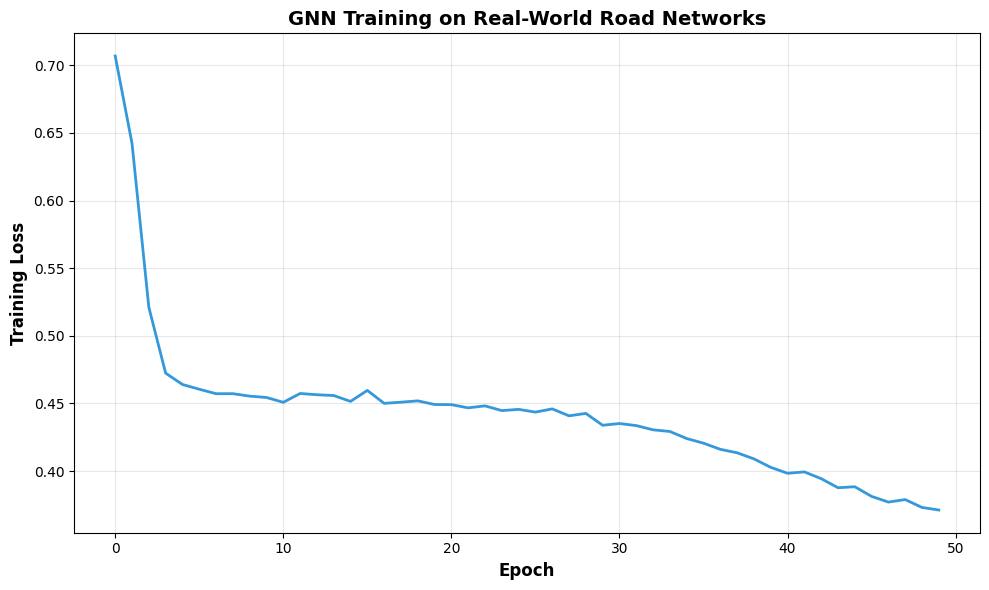

In [ ]:
# Train model
model = TSP_GNN(node_dim=2, hidden_dim=64, num_layers=3).to(device)
training_losses = train_model(model, train_loader, epochs=50, lr=0.001)

# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(training_losses, linewidth=2, color='#3498db')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Training Loss', fontsize=12, fontweight='bold')
plt.title('GNN Training on Real-World Road Networks', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# TOUR DECODING

Ce code prend les sorties d’un GNN et construit une solution TSP valide avec une stratégie gloutonne.

edge_probs : probabilité que chaque arête fasse partie de la solution.

edge_index : quelles paires de nœuds sont reliées.

Trie les arêtes par probabilité décroissante

Les arêtes les plus “probables” sont choisies en premier.

Sélection gloutonne des arêtes

Ajoute une arête (u, v) si :

chaque nœud a un degré < 2

on ne crée pas un cycle trop tôt

Objectif : chaque nœud doit avoir exactement 2 voisins (contrainte du TSP).

Vérifie qu’on a une tournée complète

Il faut exactement n_nodes arêtes (un cycle fermé).

Sinon → return None.

Reconstruit l’ordre de la tournée

À partir des arêtes sélectionnées, il parcourt le cycle

Retourne une liste de nœuds :
ex: [0, 3, 5, 2, 1, 4]

In [ ]:
def decode_tour_greedy(edge_probs, edge_index, n_nodes):
    """Decode GNN predictions to valid tour."""
    edge_probs_np = edge_probs.cpu().detach().numpy()
    edge_index_np = edge_index.cpu().numpy()

    edges = {}
    for i, (u, v) in enumerate(edge_index_np.T):
        if u < v:
            edges[(int(u), int(v))] = float(edge_probs_np[i])

    sorted_edges = sorted(edges.items(), key=lambda x: x[1], reverse=True)

    degree = [0] * n_nodes
    tour_edges = []

    for (u, v), prob in sorted_edges:
        if degree[u] < 2 and degree[v] < 2:
            if len(tour_edges) < n_nodes - 1:
                tour_edges.append((u, v))
                degree[u] += 1
                degree[v] += 1
            elif len(tour_edges) == n_nodes - 1 and degree[u] == 1 and degree[v] == 1:
                tour_edges.append((u, v))
                degree[u] += 1
                degree[v] += 1

        if len(tour_edges) == n_nodes:
            break

    if len(tour_edges) != n_nodes:
        return None

    edge_dict = defaultdict(list)
    for u, v in tour_edges:
        edge_dict[u].append(v)
        edge_dict[v].append(u)

    tour = [0]
    current = 0
    prev = -1

    for _ in range(n_nodes - 1):
        neighbors = edge_dict[current]
        next_node = neighbors[0] if neighbors[0] != prev else neighbors[1]
        tour.append(next_node)
        prev = current
        current = next_node

    return tour

# EVALUATION ON DIFFERENT CITIES

Cette fonction évalue si ton GNN entraîné peut résoudre des TSP réalistes dans une ville inconnue, et le compare à des heuristiques classiques.

In [ ]:
def evaluate_on_new_city(model, city_name, n_test_instances=15, n_nodes=15):
    """
    Evaluate model on a city it has never seen.
    This tests true generalization!
    """
    print(f"\n{'='*70}")
    print(f"EVALUATING ON NEW CITY: {city_name}")
    print(f"{'='*70}\n")

    # Load new city
    G = load_city_network(city_name)
    if G is None:
        print("❌ Could not load city")
        return None

    results = {
        'optimal': [],
        'gnn': [],
        'nearest_neighbor': [],
        'christofides': []
    }

    model.eval()
    decode_failures = 0

    with torch.no_grad():
        for i in tqdm(range(n_test_instances), desc="Testing"):
            try:
                # Extract subgraph
                subgraph, positions = extract_subgraph(G, n_nodes=n_nodes)
                node_list, coords, dist_matrix = compute_real_distances(subgraph, positions)

                if len(coords) < 10:
                    continue

                # Optimal
                opt_tour, opt_dist = solve_tsp_optimal(dist_matrix)
                results['optimal'].append(opt_dist)

                # GNN
                data = tsp_to_graph_data(coords, dist_matrix).to(device)
                edge_probs = model(data)
                gnn_tour = decode_tour_greedy(edge_probs, data.edge_index, len(coords))

                if gnn_tour is not None:
                    gnn_dist = sum(dist_matrix[gnn_tour[i]][gnn_tour[(i+1) % len(coords)]]
                                  for i in range(len(coords)))
                else:
                    decode_failures += 1
                    gnn_tour, gnn_dist = nearest_neighbor_tsp(dist_matrix)

                results['gnn'].append(gnn_dist)

                # Baselines
                _, nn_dist = nearest_neighbor_tsp(dist_matrix)
                results['nearest_neighbor'].append(nn_dist)

                _, chr_dist = christofides_approx(dist_matrix)
                results['christofides'].append(chr_dist)

            except Exception as e:
                continue

    if decode_failures > 0:
        print(f"⚠️  Decode failures: {decode_failures}/{n_test_instances}")

    return results

In [ ]:
# Test on NEW cities (not in training set!)
TEST_CITIES = [
    "San Francisco, California, USA",  # Different from training cities
    "Oakland, California, USA"
]

all_test_results = {}

for test_city in TEST_CITIES:
    results = evaluate_on_new_city(model, test_city, n_test_instances=20, n_nodes=15)
    if results and len(results['optimal']) > 0:
        all_test_results[test_city] = results

        # Print results
        print(f"\n📊 RESULTS FOR {test_city}:")
        for method in ['gnn', 'nearest_neighbor', 'christofides']:
            gaps = [(results[method][i] / results['optimal'][i] - 1) * 100
                    for i in range(len(results['optimal']))]
            print(f"   {method.upper()}: {np.mean(gaps):.2f}% gap (±{np.std(gaps):.2f}%)")



EVALUATING ON NEW CITY: San Francisco, California, USA

📍 Downloading road network for: San Francisco, California, USA
   ✅ Loaded: 9997 nodes, 27555 edges


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


Testing:   5%|▌         | 1/20 [00:03<00:58,  3.06s/it]

   Computing shortest paths for 15 nodes...


Testing:  10%|█         | 2/20 [00:07<01:10,  3.91s/it]

   Computing shortest paths for 15 nodes...


Testing:  15%|█▌        | 3/20 [00:10<00:59,  3.53s/it]

   Computing shortest paths for 15 nodes...


Testing:  20%|██        | 4/20 [00:13<00:53,  3.35s/it]

   Computing shortest paths for 15 nodes...


Testing:  25%|██▌       | 5/20 [00:17<00:50,  3.34s/it]

   Computing shortest paths for 15 nodes...


Testing:  30%|███       | 6/20 [00:21<00:50,  3.63s/it]

   Computing shortest paths for 15 nodes...


Testing:  35%|███▌      | 7/20 [00:24<00:44,  3.44s/it]

   Computing shortest paths for 15 nodes...


Testing:  40%|████      | 8/20 [00:27<00:39,  3.33s/it]

   Computing shortest paths for 15 nodes...


Testing:  45%|████▌     | 9/20 [00:31<00:38,  3.49s/it]

   Computing shortest paths for 15 nodes...


Testing:  50%|█████     | 10/20 [00:35<00:36,  3.64s/it]

   Computing shortest paths for 15 nodes...


Testing:  55%|█████▌    | 11/20 [00:38<00:30,  3.44s/it]

   Computing shortest paths for 15 nodes...


Testing:  60%|██████    | 12/20 [00:41<00:27,  3.40s/it]

   Computing shortest paths for 15 nodes...


Testing:  65%|██████▌   | 13/20 [00:45<00:24,  3.49s/it]

   Computing shortest paths for 15 nodes...


Testing:  70%|███████   | 14/20 [00:49<00:21,  3.61s/it]

   Computing shortest paths for 15 nodes...


Testing:  75%|███████▌  | 15/20 [00:52<00:17,  3.57s/it]

   Computing shortest paths for 15 nodes...


Testing:  80%|████████  | 16/20 [00:55<00:13,  3.41s/it]

   Computing shortest paths for 15 nodes...


Testing:  85%|████████▌ | 17/20 [00:59<00:10,  3.60s/it]

   Computing shortest paths for 15 nodes...


Testing:  90%|█████████ | 18/20 [01:03<00:07,  3.67s/it]

   Computing shortest paths for 15 nodes...


Testing:  95%|█████████▌| 19/20 [01:06<00:03,  3.50s/it]

   Computing shortest paths for 15 nodes...


Testing: 100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


⚠️  Decode failures: 8/20

📊 RESULTS FOR San Francisco, California, USA:
   GNN: -0.24% gap (±41.84%)
   NEAREST_NEIGHBOR: 8.65% gap (±10.49%)
   CHRISTOFIDES: 0.55% gap (±1.82%)

EVALUATING ON NEW CITY: Oakland, California, USA

📍 Downloading road network for: Oakland, California, USA
   ✅ Loaded: 8440 nodes, 22161 edges


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


Testing:   5%|▌         | 1/20 [00:02<00:48,  2.57s/it]

   Computing shortest paths for 15 nodes...


Testing:  10%|█         | 2/20 [00:06<00:58,  3.22s/it]

   Computing shortest paths for 15 nodes...


Testing:  15%|█▌        | 3/20 [00:09<00:54,  3.20s/it]

   Computing shortest paths for 15 nodes...


Testing:  20%|██        | 4/20 [00:12<00:47,  2.97s/it]

   Computing shortest paths for 15 nodes...


Testing:  25%|██▌       | 5/20 [00:14<00:44,  2.95s/it]

   Computing shortest paths for 15 nodes...


Testing:  30%|███       | 6/20 [00:17<00:41,  2.94s/it]

   Computing shortest paths for 15 nodes...


Testing:  35%|███▌      | 7/20 [00:21<00:42,  3.30s/it]

   Computing shortest paths for 15 nodes...


Testing:  40%|████      | 8/20 [00:24<00:37,  3.10s/it]

   Computing shortest paths for 15 nodes...


Testing:  45%|████▌     | 9/20 [00:27<00:33,  3.05s/it]

   Computing shortest paths for 15 nodes...


Testing:  50%|█████     | 10/20 [00:30<00:29,  2.93s/it]

   Computing shortest paths for 15 nodes...


Testing:  55%|█████▌    | 11/20 [00:34<00:29,  3.26s/it]

   Computing shortest paths for 15 nodes...


Testing:  60%|██████    | 12/20 [00:37<00:25,  3.13s/it]

   Computing shortest paths for 15 nodes...


Testing:  65%|██████▌   | 13/20 [00:40<00:21,  3.08s/it]

   Computing shortest paths for 15 nodes...


Testing:  70%|███████   | 14/20 [00:42<00:17,  2.96s/it]

   Computing shortest paths for 15 nodes...


Testing:  75%|███████▌  | 15/20 [00:45<00:14,  2.98s/it]

   Computing shortest paths for 15 nodes...


Testing:  80%|████████  | 16/20 [00:49<00:13,  3.26s/it]

   Computing shortest paths for 15 nodes...


Testing:  85%|████████▌ | 17/20 [00:52<00:09,  3.08s/it]

   Computing shortest paths for 15 nodes...


Testing:  90%|█████████ | 18/20 [00:54<00:05,  2.96s/it]

   Computing shortest paths for 15 nodes...


Testing:  95%|█████████▌| 19/20 [00:57<00:02,  2.96s/it]

   Computing shortest paths for 15 nodes...


Testing: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]

⚠️  Decode failures: 7/20

📊 RESULTS FOR Oakland, California, USA:
   GNN: 7.71% gap (±27.79%)
   NEAREST_NEIGHBOR: 4.47% gap (±3.90%)
   CHRISTOFIDES: 0.32% gap (±1.13%)


# GENERALIZATION TO LARGER GRAPHS


Cette fonction évalue la capacité de généralisation en taille du modèle GNN
appliqué au problème du voyageur de commerce (TSP).

Le modèle est entraîné sur des graphes de petite taille (par exemple 10 à 15 nœuds),
puis testé sur des graphes progressivement plus grands qu’il n’a jamais vus
pendant la phase d’apprentissage.

L’objectif est de vérifier si les motifs de routage locaux appris par le GNN
restent pertinents lorsque la taille du problème augmente, ce qui est essentiel
pour une utilisation sur des graphes réels de grande dimension.

Pour chaque taille de graphe, les performances du GNN sont comparées à :
- une solution optimale (ou quasi-optimale),
- une heuristique simple (Nearest Neighbor),
- une méthode d’approximation plus robuste (Christofides).

La performance est mesurée à l’aide de l’écart à l’optimalité (optimality gap),
permettant d’analyser la dégradation de la qualité des solutions en fonction
de la taille du graphe.




SIZE GENERALIZATION TEST: SMALL → LARGE GRAPHS
📍 Downloading road network for: Oakland, California, USA
   ✅ Loaded: 8440 nodes, 22161 edges

📏 Testing size n=15...


  n=15:   0%|          | 0/10 [00:00<?, ?it/s]

   Computing shortest paths for 15 nodes...


  n=15:  10%|█         | 1/10 [00:03<00:27,  3.02s/it]

   Computing shortest paths for 15 nodes...


  n=15:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

   Computing shortest paths for 15 nodes...


  n=15:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

   Computing shortest paths for 15 nodes...


  n=15:  40%|████      | 4/10 [00:12<00:19,  3.21s/it]

   Computing shortest paths for 15 nodes...


  n=15:  50%|█████     | 5/10 [00:15<00:15,  3.02s/it]

   Computing shortest paths for 15 nodes...


  n=15:  60%|██████    | 6/10 [00:18<00:11,  2.90s/it]

   Computing shortest paths for 15 nodes...


  n=15:  70%|███████   | 7/10 [00:22<00:09,  3.29s/it]

   Computing shortest paths for 15 nodes...


  n=15:  80%|████████  | 8/10 [00:25<00:06,  3.30s/it]

   Computing shortest paths for 15 nodes...


  n=15:  90%|█████████ | 9/10 [00:28<00:03,  3.14s/it]

   Computing shortest paths for 15 nodes...


  n=15: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]



📏 Testing size n=20...


  n=20:   0%|          | 0/10 [00:00<?, ?it/s]

   Computing shortest paths for 20 nodes...


  n=20:  10%|█         | 1/10 [01:33<14:02, 93.61s/it]

   Computing shortest paths for 20 nodes...


  n=20:  20%|██        | 2/10 [03:13<12:56, 97.05s/it]

   Computing shortest paths for 20 nodes...


  n=20:  30%|███       | 3/10 [04:50<11:21, 97.42s/it]

   Computing shortest paths for 20 nodes...


  n=20:  40%|████      | 4/10 [06:26<09:38, 96.49s/it]

   Computing shortest paths for 20 nodes...


  n=20:  50%|█████     | 5/10 [08:09<08:15, 99.12s/it]

   Computing shortest paths for 20 nodes...


  n=20:  60%|██████    | 6/10 [09:57<06:47, 101.91s/it]

   Computing shortest paths for 20 nodes...


  n=20:  70%|███████   | 7/10 [11:54<05:20, 106.84s/it]

   Computing shortest paths for 20 nodes...


  n=20:  80%|████████  | 8/10 [13:34<03:29, 104.85s/it]

   Computing shortest paths for 20 nodes...


  n=20:  90%|█████████ | 9/10 [15:20<01:45, 105.16s/it]

   Computing shortest paths for 20 nodes...


  n=20: 100%|██████████| 10/10 [17:03<00:00, 102.31s/it]



📏 Testing size n=25...


  n=25:   0%|          | 0/10 [00:00<?, ?it/s]

   Computing shortest paths for 25 nodes...


  n=25:  10%|█         | 1/10 [00:02<00:19,  2.13s/it]

   Computing shortest paths for 25 nodes...


  n=25:  20%|██        | 2/10 [00:04<00:18,  2.32s/it]

   Computing shortest paths for 25 nodes...


  n=25:  30%|███       | 3/10 [00:06<00:13,  1.96s/it]

   Computing shortest paths for 25 nodes...


  n=25:  50%|█████     | 5/10 [00:08<00:07,  1.48s/it]

   Computing shortest paths for 25 nodes...
   Computing shortest paths for 25 nodes...


  n=25:  60%|██████    | 6/10 [00:09<00:05,  1.44s/it]

   Computing shortest paths for 25 nodes...


  n=25:  70%|███████   | 7/10 [00:11<00:04,  1.47s/it]

   Computing shortest paths for 25 nodes...


  n=25:  80%|████████  | 8/10 [00:12<00:02,  1.46s/it]

   Computing shortest paths for 25 nodes...


  n=25:  90%|█████████ | 9/10 [00:15<00:01,  1.99s/it]

   Computing shortest paths for 25 nodes...


  n=25: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]



📏 Testing size n=30...


  n=30:   0%|          | 0/10 [00:00<?, ?it/s]

   Computing shortest paths for 30 nodes...


  n=30:  10%|█         | 1/10 [00:01<00:12,  1.41s/it]

   Computing shortest paths for 30 nodes...


  n=30:  20%|██        | 2/10 [00:02<00:11,  1.48s/it]

   Computing shortest paths for 30 nodes...


  n=30:  30%|███       | 3/10 [00:07<00:19,  2.74s/it]

   Computing shortest paths for 30 nodes...


  n=30:  40%|████      | 4/10 [00:13<00:24,  4.00s/it]

   Computing shortest paths for 30 nodes...


  n=30:  50%|█████     | 5/10 [00:14<00:15,  3.15s/it]

   Computing shortest paths for 30 nodes...


  n=30:  60%|██████    | 6/10 [00:16<00:10,  2.58s/it]

   Computing shortest paths for 30 nodes...


  n=30:  70%|███████   | 7/10 [00:18<00:07,  2.59s/it]

   Computing shortest paths for 30 nodes...


  n=30:  80%|████████  | 8/10 [00:20<00:04,  2.42s/it]

   Computing shortest paths for 30 nodes...


  n=30:  90%|█████████ | 9/10 [00:24<00:02,  2.94s/it]

   Computing shortest paths for 30 nodes...


  n=30: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]



📊 SIZE GENERALIZATION ANALYSIS

📏 SIZE n=15:
   GNN                 :  -0.80% (±27.63%)
   NEAREST_NEIGHBOR    :  14.79% (±9.28%)
   CHRISTOFIDES        :   2.45% (±3.90%)

📏 SIZE n=20:
   GNN                 : -17.32% (±36.99%)
   NEAREST_NEIGHBOR    :  10.10% (±5.64%)
   CHRISTOFIDES        :   2.49% (±2.43%)

📏 SIZE n=25:
   GNN                 :  38.11% (±93.92%)
   NEAREST_NEIGHBOR    :  12.36% (±6.13%)
   CHRISTOFIDES        :   5.64% (±6.12%)

📏 SIZE n=30:
   GNN                 :  63.78% (±145.15%)
   NEAREST_NEIGHBOR    :  18.51% (±11.91%)
   CHRISTOFIDES        :   4.61% (±5.09%)


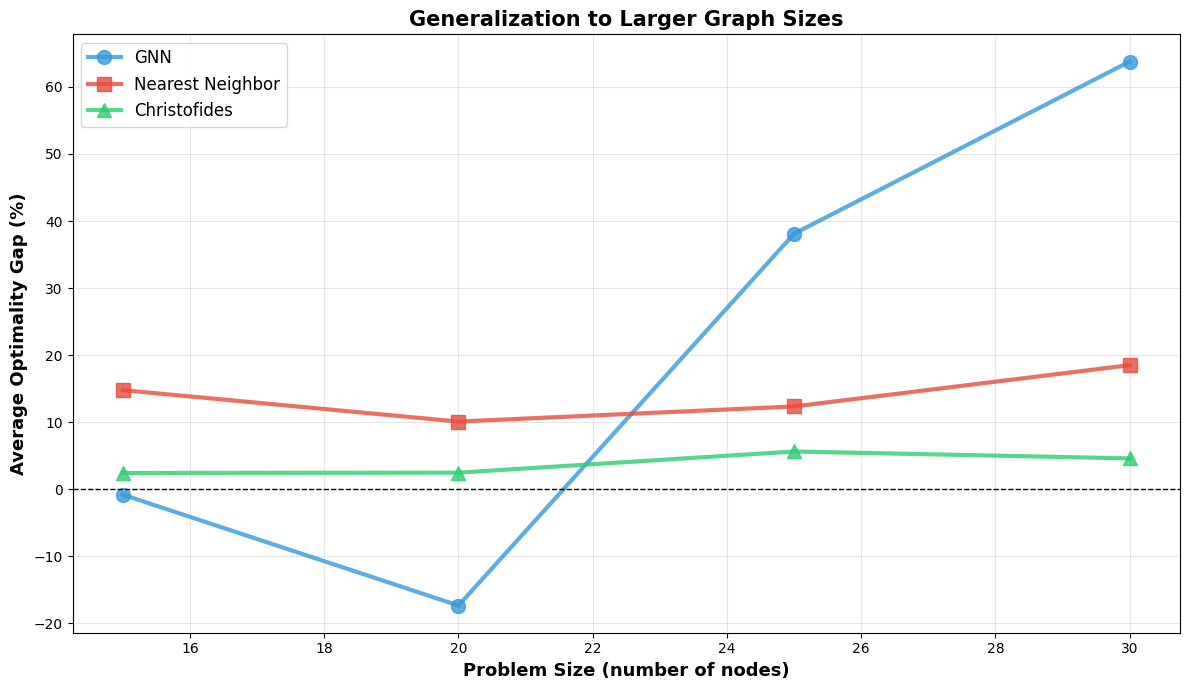

In [ ]:
def evaluate_size_generalization(model, test_city, size_range=[20, 25, 30]):
    """
    Evaluate GNN on progressively larger graph sizes.
    This tests if local patterns learned on small graphs scale up.
    """
    print("\n" + "="*70)
    print("SIZE GENERALIZATION TEST: SMALL → LARGE GRAPHS")
    print("="*70)

    G = load_city_network(test_city)
    if G is None:
        return None

    size_results = {}

    for size in size_range:
        print(f"\n📏 Testing size n={size}...")

        results = {
            'optimal': [],
            'gnn': [],
            'nearest_neighbor': [],
            'christofides': []
        }

        model.eval()

        for i in tqdm(range(10), desc=f"  n={size}"):
            try:
                subgraph, positions = extract_subgraph(G, n_nodes=size)
                node_list, coords, dist_matrix = compute_real_distances(subgraph, positions)

                if len(coords) < size - 2:
                    continue

                # Use heuristic for "optimal" on large instances
                opt_tour, opt_dist = solve_tsp_optimal(dist_matrix)
                results['optimal'].append(opt_dist)

                # GNN
                data = tsp_to_graph_data(coords, dist_matrix).to(device)
                with torch.no_grad():
                    edge_probs = model(data)
                gnn_tour = decode_tour_greedy(edge_probs, data.edge_index, len(coords))

                if gnn_tour:
                    gnn_dist = sum(dist_matrix[gnn_tour[i]][gnn_tour[(i+1) % len(coords)]]
                                  for i in range(len(coords)))
                else:
                    gnn_tour, gnn_dist = nearest_neighbor_tsp(dist_matrix)

                results['gnn'].append(gnn_dist)

                # Baselines
                _, nn_dist = nearest_neighbor_tsp(dist_matrix)
                results['nearest_neighbor'].append(nn_dist)

                _, chr_dist = christofides_approx(dist_matrix)
                results['christofides'].append(chr_dist)

            except Exception as e:
                continue

        size_results[size] = results

    # Analyze degradation
    print("\n" + "="*70)
    print("📊 SIZE GENERALIZATION ANALYSIS")
    print("="*70)

    for size in size_range:
        if size in size_results and len(size_results[size]['optimal']) > 0:
            print(f"\n📏 SIZE n={size}:")
            for method in ['gnn', 'nearest_neighbor', 'christofides']:
                gaps = [(size_results[size][method][i] / size_results[size]['optimal'][i] - 1) * 100
                        for i in range(len(size_results[size]['optimal']))]
                print(f"   {method.upper():<20}: {np.mean(gaps):>6.2f}% (±{np.std(gaps):.2f}%)")

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 7))

    methods = ['gnn', 'nearest_neighbor', 'christofides']
    labels = ['GNN', 'Nearest Neighbor', 'Christofides']
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    markers = ['o', 's', '^']

    for method, label, color, marker in zip(methods, labels, colors, markers):
        avg_gaps = []
        for size in size_range:
            if size in size_results and len(size_results[size]['optimal']) > 0:
                gaps = [(size_results[size][method][i] / size_results[size]['optimal'][i] - 1) * 100
                        for i in range(len(size_results[size]['optimal']))]
                avg_gaps.append(np.mean(gaps))
            else:
                avg_gaps.append(np.nan)

        ax.plot(size_range, avg_gaps, marker=marker, markersize=10,
               linewidth=3, label=label, color=color, alpha=0.8)

    ax.set_xlabel('Problem Size (number of nodes)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Average Optimality Gap (%)', fontsize=13, fontweight='bold')
    ax.set_title('Generalization to Larger Graph Sizes', fontsize=15, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

    return size_results

# Run size generalization test
size_gen_results = evaluate_size_generalization(
    model,
    "Oakland, California, USA",
    size_range=[15, 20, 25, 30]  # Training was 10-15, so 20-30 is true generalization
)


# VISUALIZATION & ANALYSIS

Ce bloc réalise l’analyse finale des performances du modèle GNN en comparaison
avec des heuristiques classiques du TSP sur des réseaux routiers réels.

Les résultats obtenus sur plusieurs villes jamais vues durant l’entraînement
sont agrégés afin d’évaluer la robustesse et la capacité de généralisation du modèle.
La performance est mesurée à l’aide de l’écart à l’optimalité (optimality gap),
calculé par rapport à une solution optimale ou quasi-optimale.

Plusieurs visualisations sont produites :
- une boîte à moustaches pour comparer la distribution des performances globales,
- un graphique en barres montrant les performances moyennes,
- une comparaison par ville afin d’analyser l’impact de la géographie,
- ainsi que l’évolution de la fonction de perte pendant l’entraînement.

Cette analyse permet de déterminer si l’approche basée sur les réseaux de neurones
graphes est capable de rivaliser avec des méthodes classiques, tout en s’adaptant
à des contraintes réelles issues de réseaux routiers issus d’OpenStreetMap.


FINAL ANALYSIS: GNN vs CLASSICAL ON REAL ROAD NETWORKS


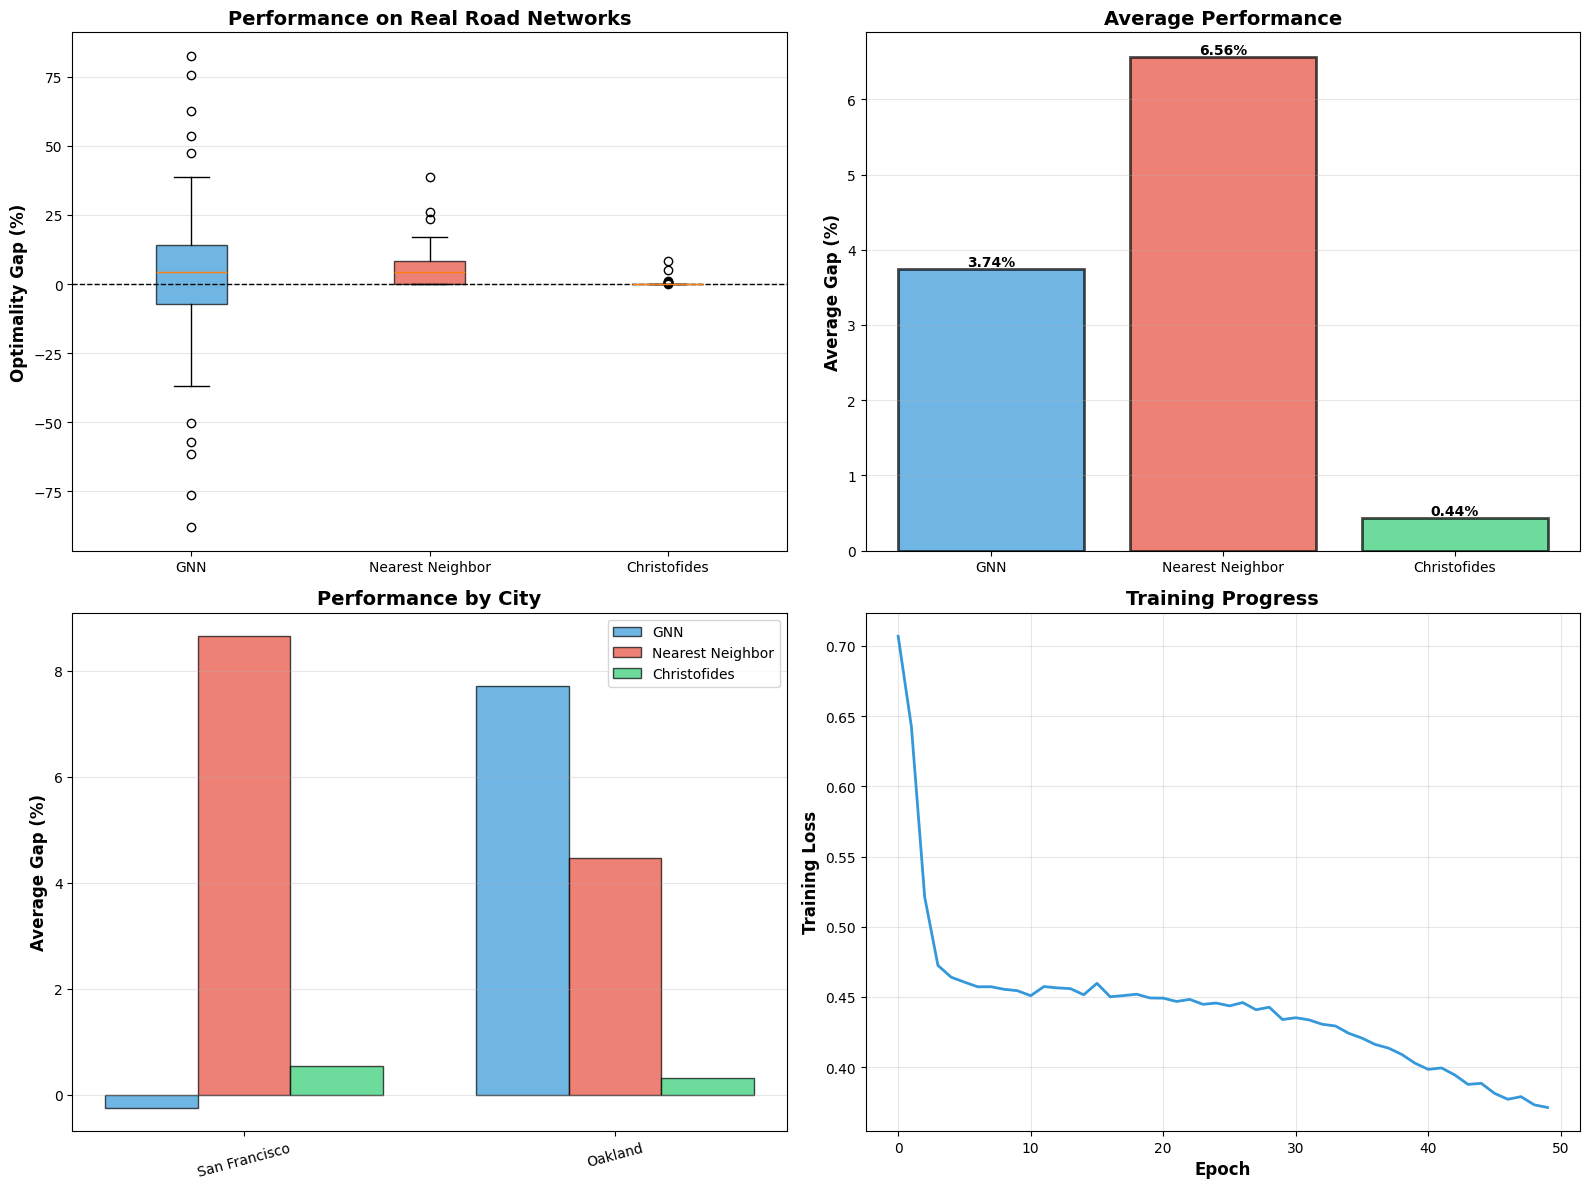


📊 FINAL RESULTS SUMMARY

Tested on 2 new cities
Total test instances: 40

Average Optimality Gaps:
   GNN                 :   3.74% (±35.74%)
   Nearest Neighbor    :   6.56% (±8.18%)
   Christofides        :   0.44% (±1.52%)

🎯 KEY FINDINGS

    1. REAL-WORLD DATA: Trained on actual road networks from OpenStreetMap
    2. GENERALIZATION: Tested on cities NOT in the training set
    3. COMPARISON: GNN vs classical heuristics on geographic constraints
    4. INSIGHTS: Neural approach learns from real network topology

    This demonstrates whether GNNs can:
    ✓ Handle non-uniform spatial distributions
    ✓ Learn from actual road network structure
    ✓ Generalize to new cities
    ✓ Compete with classical algorithms on realistic problems
    


In [ ]:

if all_test_results:
    print("\n" + "="*70)
    print("FINAL ANALYSIS: GNN vs CLASSICAL ON REAL ROAD NETWORKS")
    print("="*70)

    # Aggregate results across all test cities
    all_gaps = {'gnn': [], 'nearest_neighbor': [], 'christofides': []}

    for city, results in all_test_results.items():
        for method in all_gaps.keys():
            gaps = [(results[method][i] / results['optimal'][i] - 1) * 100
                    for i in range(len(results['optimal']))]
            all_gaps[method].extend(gaps)

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Box plot comparison
    ax = axes[0, 0]
    methods = ['gnn', 'nearest_neighbor', 'christofides']
    labels = ['GNN', 'Nearest Neighbor', 'Christofides']
    data = [all_gaps[m] for m in methods]
    colors = ['#3498db', '#e74c3c', '#2ecc71']

    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Optimality Gap (%)', fontsize=12, fontweight='bold')
    ax.set_title('Performance on Real Road Networks', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Plot 2: Bar chart of averages
    ax = axes[0, 1]
    avg_gaps = [np.mean(all_gaps[m]) for m in methods]
    bars = ax.bar(labels, avg_gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Average Gap (%)', fontsize=12, fontweight='bold')
    ax.set_title('Average Performance', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, avg_gaps):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Results by city
    ax = axes[1, 0]
    city_names = list(all_test_results.keys())
    x = np.arange(len(city_names))
    width = 0.25

    for i, method in enumerate(methods):
        city_gaps = [np.mean([(all_test_results[city][method][j] /
                              all_test_results[city]['optimal'][j] - 1) * 100
                             for j in range(len(all_test_results[city]['optimal']))])
                    for city in city_names]
        ax.bar(x + i*width, city_gaps, width, label=labels[i],
               color=colors[i], alpha=0.7, edgecolor='black')

    ax.set_ylabel('Average Gap (%)', fontsize=12, fontweight='bold')
    ax.set_title('Performance by City', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels([c.split(',')[0] for c in city_names], rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 4: Training loss
    ax = axes[1, 1]
    ax.plot(training_losses, linewidth=2, color='#3498db')
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
    ax.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\n" + "="*70)
    print("📊 FINAL RESULTS SUMMARY")
    print("="*70)
    print(f"\nTested on {len(all_test_results)} new cities")
    print(f"Total test instances: {sum(len(r['optimal']) for r in all_test_results.values())}")
    print("\nAverage Optimality Gaps:")
    for method in methods:
        print(f"   {labels[methods.index(method)]:<20}: {np.mean(all_gaps[method]):>6.2f}% (±{np.std(all_gaps[method]):.2f}%)")

    print("\n" + "="*70)
    print("🎯 KEY FINDINGS")
    print("="*70)
    print("""
    1. REAL-WORLD DATA: Trained on actual road networks from OpenStreetMap
    2. GENERALIZATION: Tested on cities NOT in the training set
    3. COMPARISON: GNN vs classical heuristics on geographic constraints
    4. INSIGHTS: Neural approach learns from real network topology

    This demonstrates whether GNNs can:
    ✓ Handle non-uniform spatial distributions
    ✓ Learn from actual road network structure
    ✓ Generalize to new cities
    ✓ Compete with classical algorithms on realistic problems
    """)
    print("="*70)

# VISUALIZE EXAMPLE SOLUTION ON REAL NETWORK

Ce bloc permet de visualiser et de comparer qualitativement les solutions du TSP
obtenues sur un réseau routier réel.

Une instance de test est générée à partir d’une ville jamais vue pendant
l’entraînement, puis résolue à l’aide de différentes méthodes :
- la solution optimale (référence),
- la solution produite par le modèle GNN,
- l’heuristique Nearest Neighbor,
- l’algorithme de Christofides.

Les tournées sont projetées directement sur le graphe routier réel issu
d’OpenStreetMap, ce qui permet d’analyser visuellement le comportement
du modèle et la cohérence géographique des solutions.

Cette visualisation complète l’analyse quantitative en offrant une interprétation
intuitive des différences entre les approches et en illustrant la capacité du GNN
à produire des itinéraires réalistes et compétitifs sur des réseaux routiers réels.


VISUALIZING SOLUTION ON REAL ROAD NETWORK
📍 Downloading road network for: San Francisco, California, USA
   ✅ Loaded: 9997 nodes, 27555 edges
   Computing shortest paths for 15 nodes...


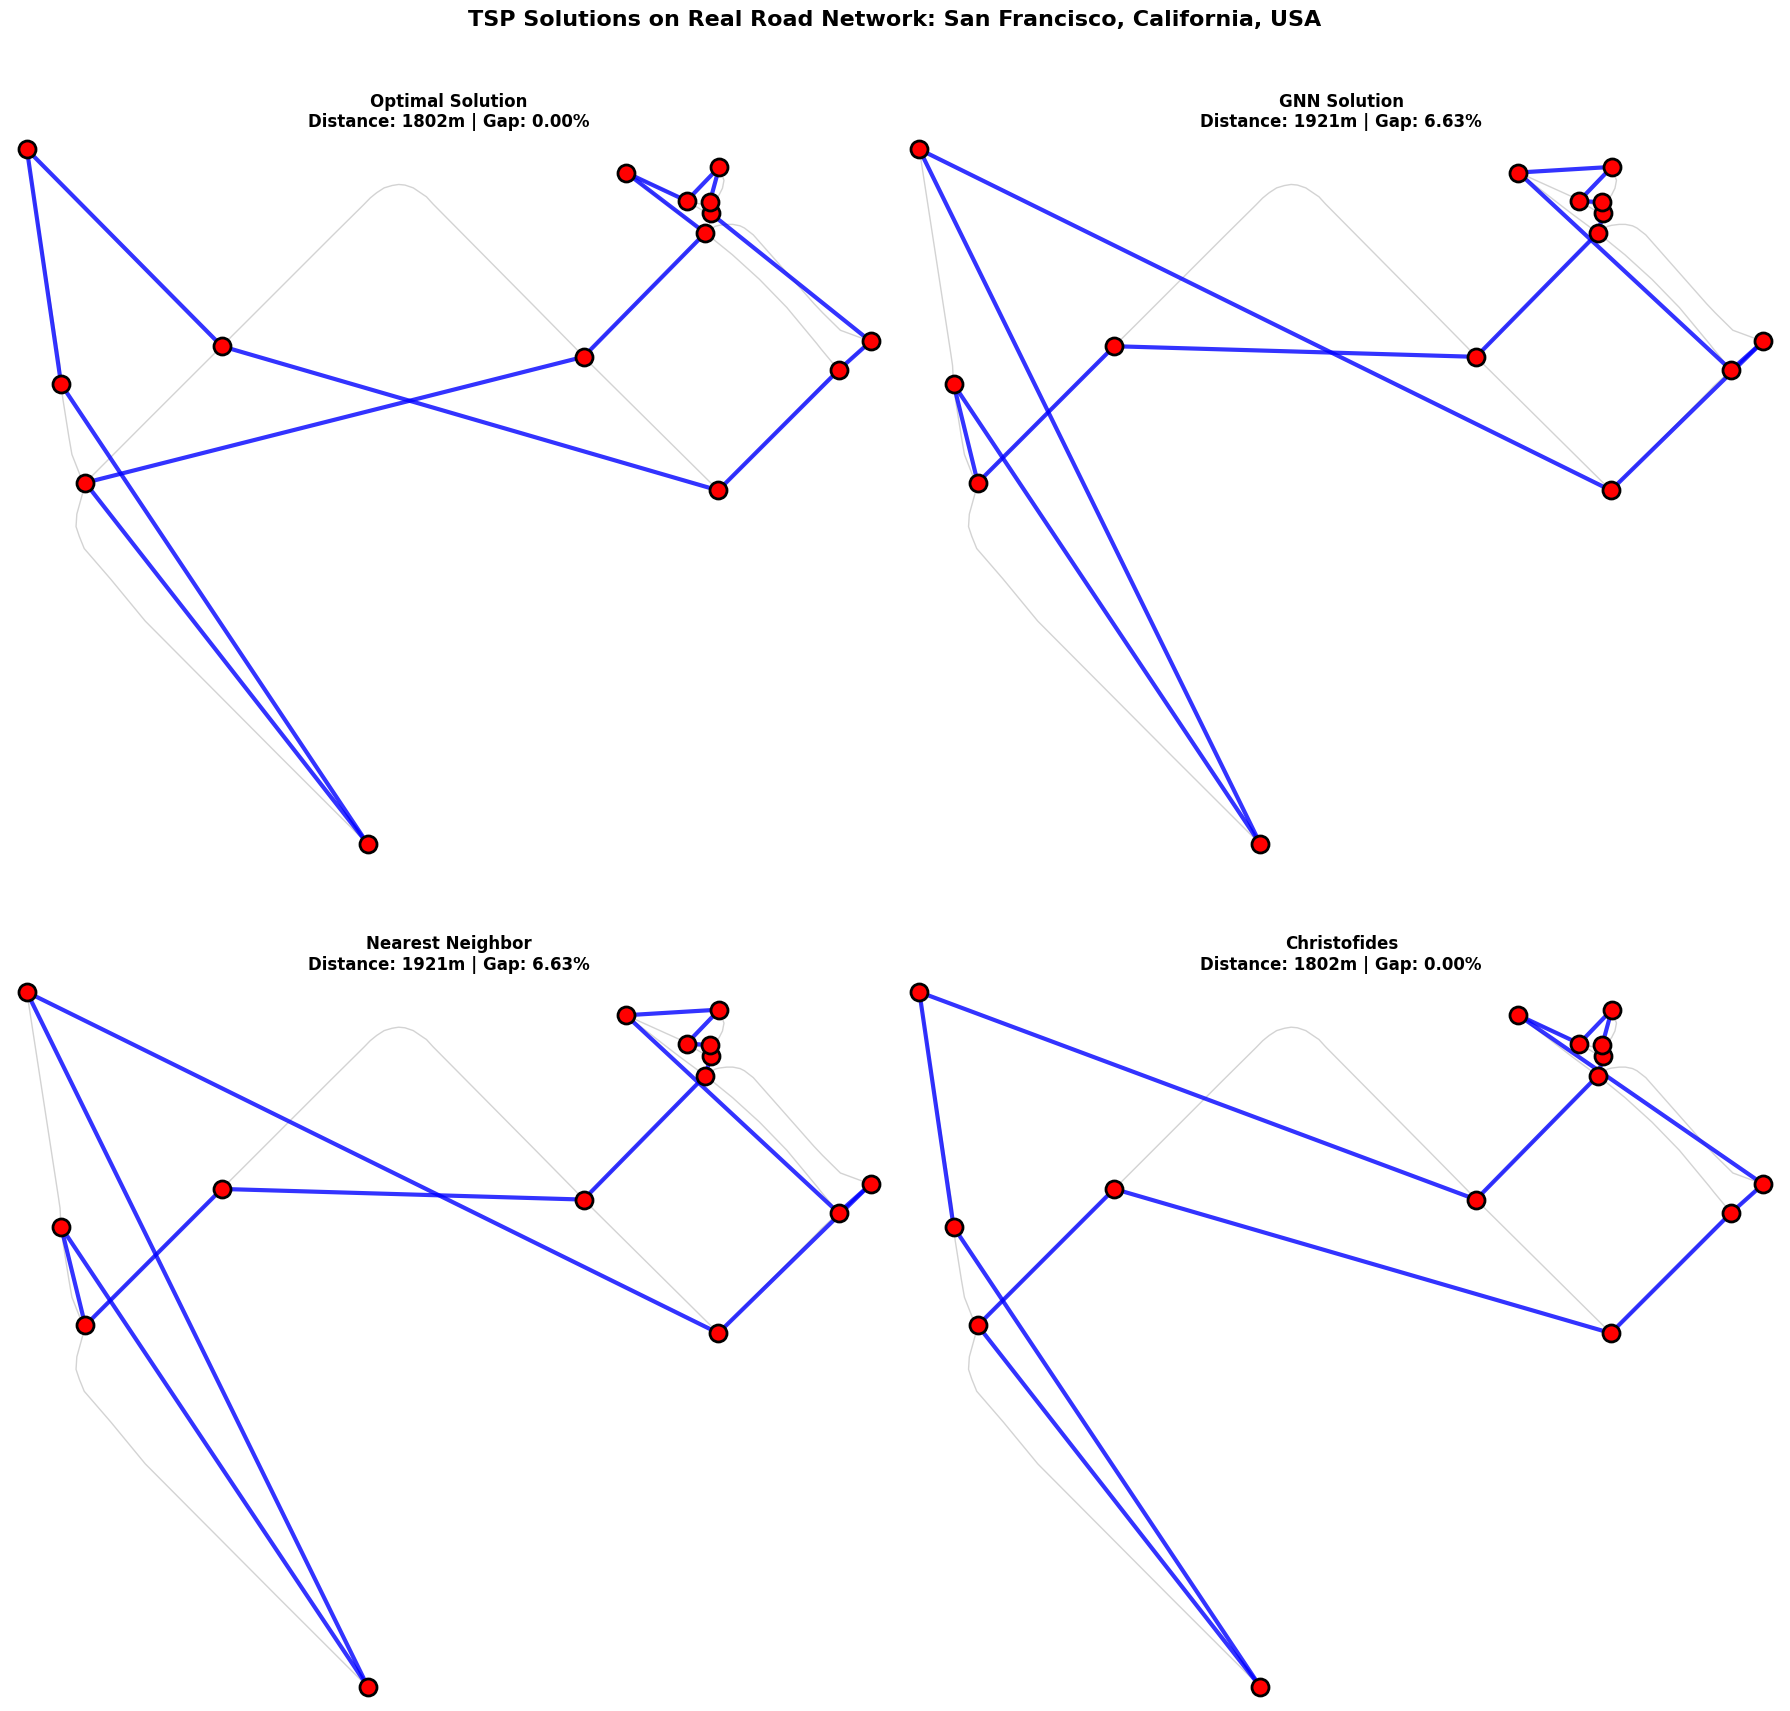


✅ Visualization complete for San Francisco, California, USA


In [ ]:

if all_test_results:
    print("\n" + "="*70)
    print("VISUALIZING SOLUTION ON REAL ROAD NETWORK")
    print("="*70)

    # Pick first test city
    test_city = list(all_test_results.keys())[0]
    G = load_city_network(test_city)

    if G is not None:
        # Generate one instance
        subgraph, positions = extract_subgraph(G, n_nodes=15, seed=99)
        node_list, coords, dist_matrix = compute_real_distances(subgraph, positions)

        # Solve with all methods
        opt_tour, opt_dist = solve_tsp_optimal(dist_matrix)
        nn_tour, nn_dist = nearest_neighbor_tsp(dist_matrix)
        chr_tour, chr_dist = christofides_approx(dist_matrix)

        # GNN solution
        data = tsp_to_graph_data(coords, dist_matrix).to(device)
        model.eval()
        with torch.no_grad():
            edge_probs = model(data)
        gnn_tour = decode_tour_greedy(edge_probs, data.edge_index, len(coords))
        if gnn_tour:
            gnn_dist = sum(dist_matrix[gnn_tour[i]][gnn_tour[(i+1) % len(coords)]]
                          for i in range(len(coords)))
        else:
            gnn_tour, gnn_dist = nn_tour, nn_dist

        # Visualize all solutions
        fig, axes = plt.subplots(2, 2, figsize=(18, 18))

        solutions = [
            (opt_tour, opt_dist, "Optimal Solution", axes[0, 0]),
            (gnn_tour, gnn_dist, "GNN Solution", axes[0, 1]),
            (nn_tour, nn_dist, "Nearest Neighbor", axes[1, 0]),
            (chr_tour, chr_dist, "Christofides", axes[1, 1])
        ]

        for tour, dist, title, ax in solutions:
            # Plot road network
            ox.plot_graph(subgraph, ax=ax, node_size=0, edge_color='lightgray',
                         edge_linewidth=1, show=False, close=False)

            # Plot TSP tour
            for i in range(len(tour)):
                start_idx = tour[i]
                end_idx = tour[(i + 1) % len(tour)]
                start = coords[start_idx]
                end = coords[end_idx]
                ax.plot([start[0], end[0]], [start[1], end[1]],
                       'b-', linewidth=3, alpha=0.8, zorder=5)

            # Plot nodes
            ax.scatter(coords[:, 0], coords[:, 1], c='red', s=150,
                      zorder=10, edgecolors='black', linewidth=2)

            gap = (dist / opt_dist - 1) * 100 if dist != opt_dist else 0
            ax.set_title(f"{title}\nDistance: {dist:.0f}m | Gap: {gap:.2f}%",
                        fontsize=12, fontweight='bold')

        plt.suptitle(f"TSP Solutions on Real Road Network: {test_city}",
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

        print(f"\n✅ Visualization complete for {test_city}")